In [ ]:
import numpy as np
import pandas as pd
import h5py
import random
from tqdm import tqdm
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.serif": ["Computer Modern Roman"]})

from meta_feature import dataset_ids_CC18, anchor_list_denser, feature_num_CC18, class_num_CC18, learner_zoo
from utils import fit_model, global_monotonicity_violation, global_convexity_violation, curves_models_fitting

In [2]:
file_paths = Path.cwd() / '../dataset/LCDB11_ER_CC18_24.hdf5'
dataset_CC18 = h5py.File(file_paths , 'r')['error rate'][...] 
dataset_nofs, dataset_minmaxfs, dataset_standardfs = dataset_CC18[..., 0, 0], dataset_CC18[..., 1, 0], dataset_CC18[..., 2, 0]

mean_valid_lc_nofs = np.nanmean(dataset_nofs[:,:,:,:,:,1], axis=(2,3))
mean_valid_lc_minmaxfs = np.nanmean(dataset_minmaxfs[:,:,:,:,:,1], axis=(2,3))
mean_valid_lc_standardfs = np.nanmean(dataset_standardfs[:,:,:,:,:,1], axis=(2,3))

In [3]:
mono_matrix_y, mono_matrix_x = global_monotonicity_violation(dataset_nofs, flat_filter = True)
conv_matrix, conv_h_matrix, conv_i_matrix, conv_j_matrix = global_convexity_violation(dataset_nofs, flat_filter = True)

100%|██████████| 72/72 [01:21<00:00,  1.13s/it]


In [11]:
parametric_model = 'wbl4' # 'pow4', 'mmf4', 'wbl4'

fit_MSE_matrix = np.full((dataset_nofs.shape[1], dataset_nofs.shape[0]), np.nan) 
for LEARNER in tqdm(range(23)):   # exclude dummy
    for DATASET in range(72): 
        try:
            fitting_results = curves_models_fitting(mean_valid_lc_nofs[DATASET, LEARNER, :], [parametric_model], 
                                extrapolate=False, mask_anchor_number=0, eval_anchor_number=0, rep = 5)
            result_df = pd.DataFrame(fitting_results)
            best_mse = result_df["mse"].min()  # mean or min
            fit_MSE_matrix[LEARNER, DATASET] = best_mse
        except: 
            pass

100%|██████████| 23/23 [00:53<00:00,  2.34s/it]


Welch's t-test (Monotonicity), p-value 6.0107582024581145e-05
Welch's t-test (Convexity), p-value 5.9066908995846025e-06


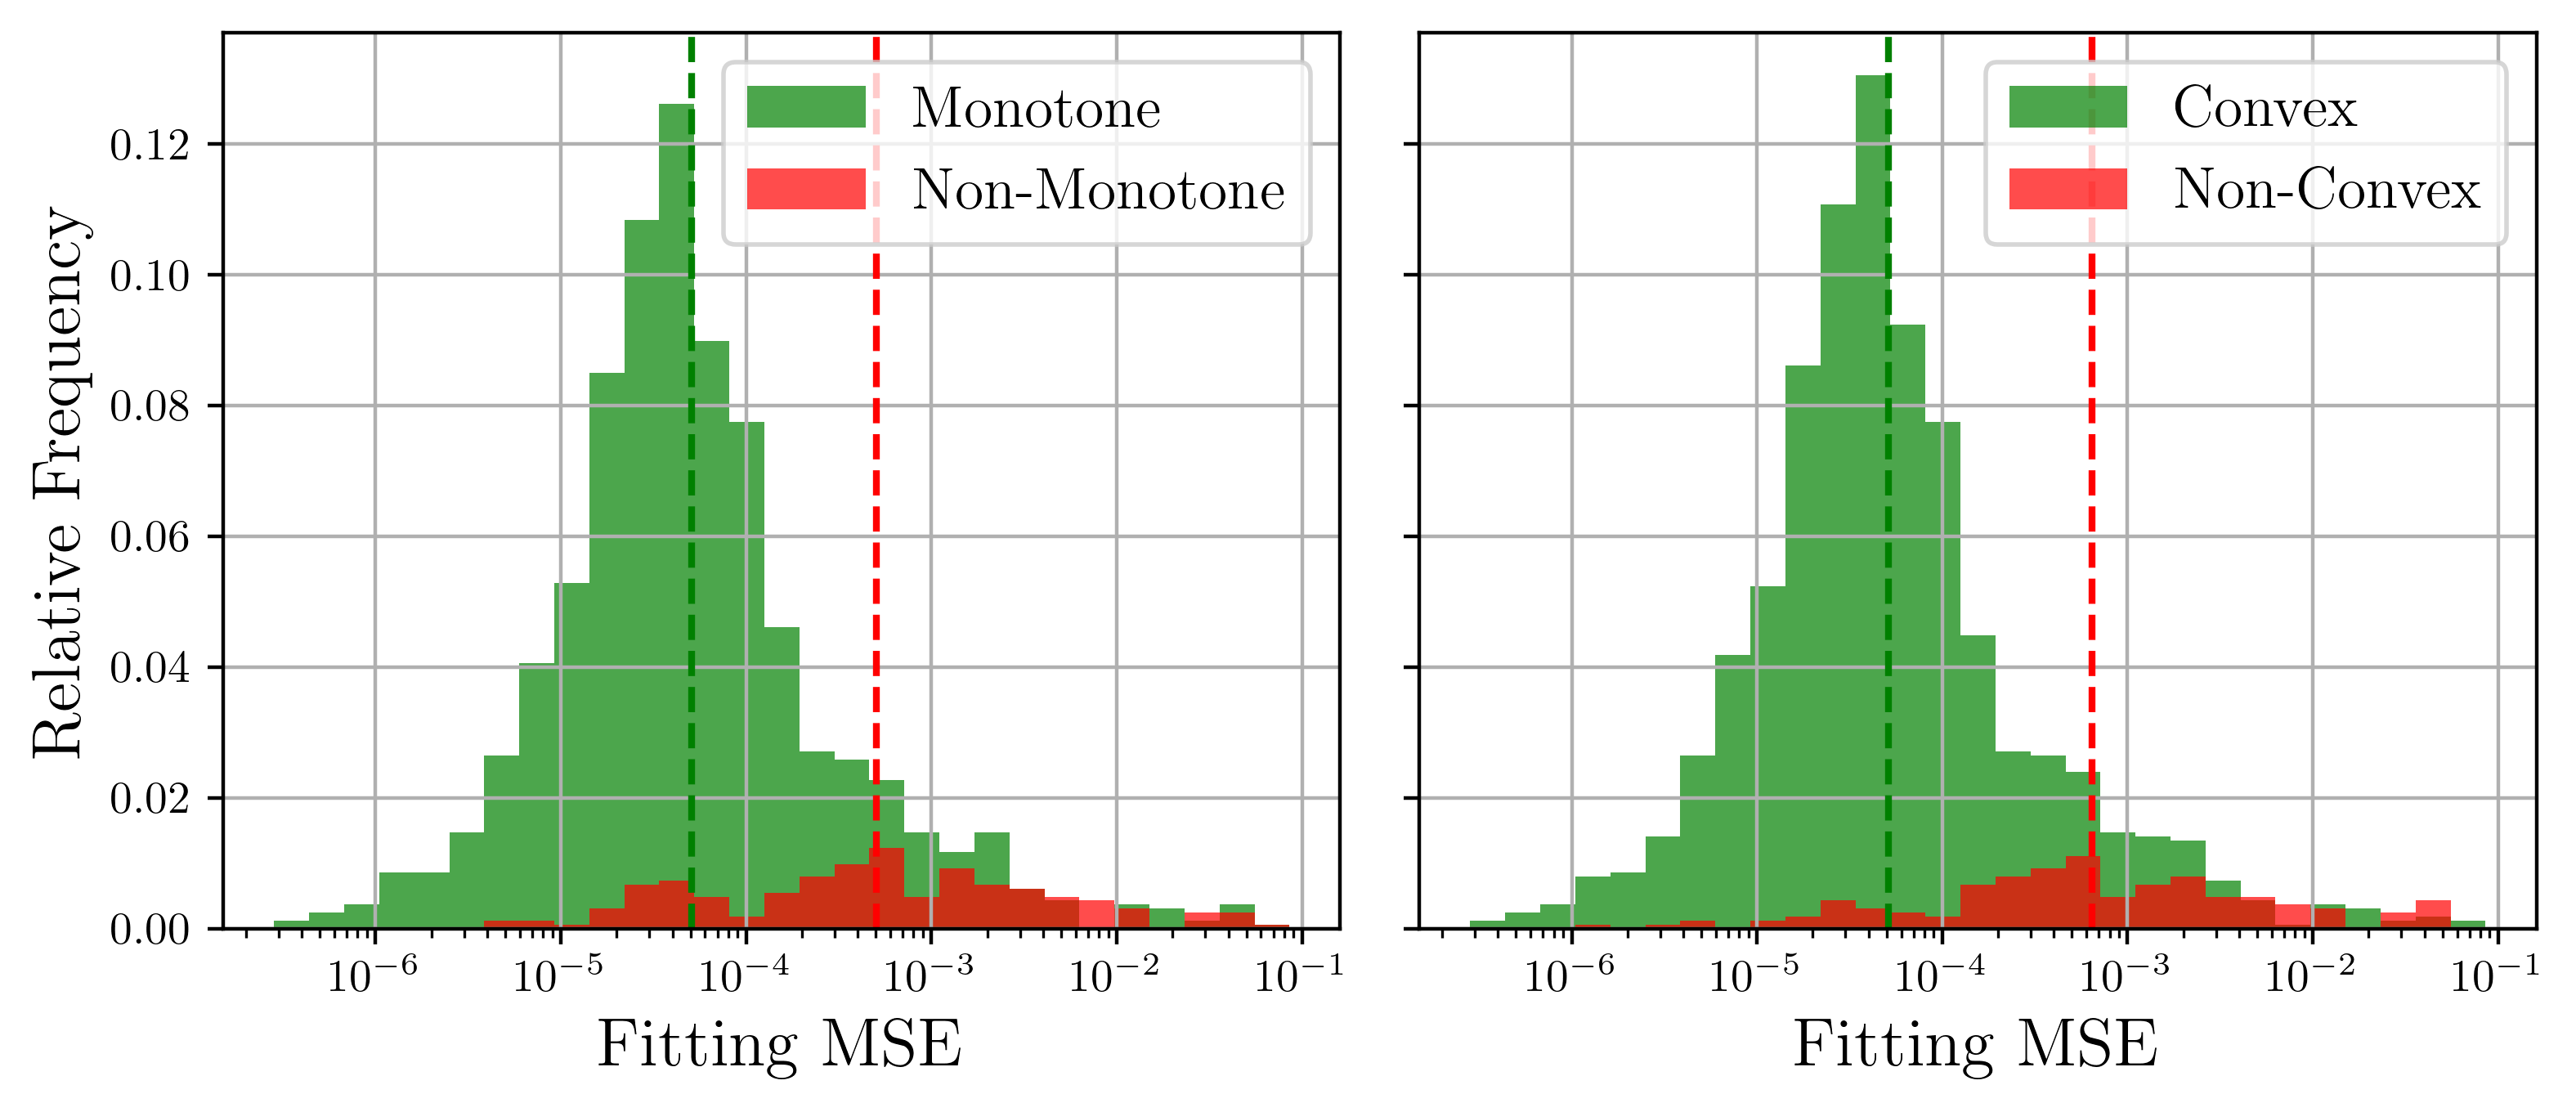

In [12]:
MSE_values_1 = fit_MSE_matrix.flatten()
y_values_1 = mono_matrix_y.flatten()
valid_mask_1 = ~np.isnan(MSE_values_1) & ~np.isnan(y_values_1)
x_valid_well_1 = MSE_values_1[valid_mask_1 & (y_values_1 == 0)]
x_valid_violated_1 = MSE_values_1[valid_mask_1 & (y_values_1 > 0)]

t_stat, p_value = ttest_ind(x_valid_well_1, x_valid_violated_1, equal_var=False)  # Welch's t-test
print("Welch's t-test (Monotonicity), p-value", p_value)

MSE_values_2 = fit_MSE_matrix.flatten()
y_values_2 = conv_matrix.flatten()
valid_mask_2 = ~np.isnan(MSE_values_2) & ~np.isnan(y_values_2)
x_valid_well_2 = MSE_values_2[valid_mask_2 & (y_values_2 == 0)]
x_valid_violated_2 = MSE_values_2[valid_mask_2 & (y_values_2 > 0)]

t_stat, p_value = ttest_ind(x_valid_well_2, x_valid_violated_2, equal_var=False)  # Welch's t-test
print("Welch's t-test (Convexity), p-value", p_value)

# logarithmic bins for all plots
overall_min_bin = min(np.min(x_valid_well_1), np.min(x_valid_violated_1),
                      np.min(x_valid_well_2), np.min(x_valid_violated_2))
overall_max_bin = max(np.max(x_valid_well_1), np.max(x_valid_violated_1),
                      np.max(x_valid_well_2), np.max(x_valid_violated_2))
bins = np.logspace(np.log10(overall_min_bin), np.log10(overall_max_bin), 30)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 3.5), dpi=400, sharey=True)

# Plot 1
weights_well_1 = np.ones_like(x_valid_well_1) / valid_mask_1.sum()
weights_violated_1 = np.ones_like(x_valid_violated_1) / valid_mask_1.sum()
log_mean_well_1 = np.exp(np.mean(np.log(x_valid_well_1)))
log_mean_violated_1 = np.exp(np.mean(np.log(x_valid_violated_1)))
axes[0].hist(x_valid_well_1, bins=bins, weights=weights_well_1, color='green', alpha=0.7, label="Monotone")
axes[0].hist(x_valid_violated_1, bins=bins, weights=weights_violated_1, color='red', alpha=0.7, label="Non-Monotone")
axes[0].axvline(log_mean_well_1, color='green', linestyle='--')
axes[0].axvline(log_mean_violated_1, color='red', linestyle='--')
axes[0].set_xscale("log")
# axes[0].set_xlim(1e-8, 1e-1)
axes[0].set_xlabel("Fitting MSE", fontsize=15)
axes[0].set_ylabel("Relative Frequency", fontsize=15)
axes[0].legend(fontsize=13)
axes[0].grid()

# Plot 2
weights_well_2 = np.ones_like(x_valid_well_2) / valid_mask_2.sum()
weights_violated_2 = np.ones_like(x_valid_violated_2) / valid_mask_2.sum()
log_mean_well_2 = np.exp(np.mean(np.log(x_valid_well_2)))
log_mean_violated_2 = np.exp(np.mean(np.log(x_valid_violated_2)))
axes[1].hist(x_valid_well_2, bins=bins, weights=weights_well_2, color='green', alpha=0.7, label="Convex")
axes[1].hist(x_valid_violated_2, bins=bins, weights=weights_violated_2, color='red', alpha=0.7, label="Non-Convex")
axes[1].axvline(log_mean_well_2, color='green', linestyle='--')
axes[1].axvline(log_mean_violated_2, color='red', linestyle='--')   # , label="Log-Mean"
axes[1].set_xscale("log")
# axes[1].set_xlim(1e-8, 1e-1)
axes[1].set_xlabel("Fitting MSE", fontsize=15)
axes[1].legend(fontsize=13)
axes[1].grid()

plt.tight_layout()
plt.show()


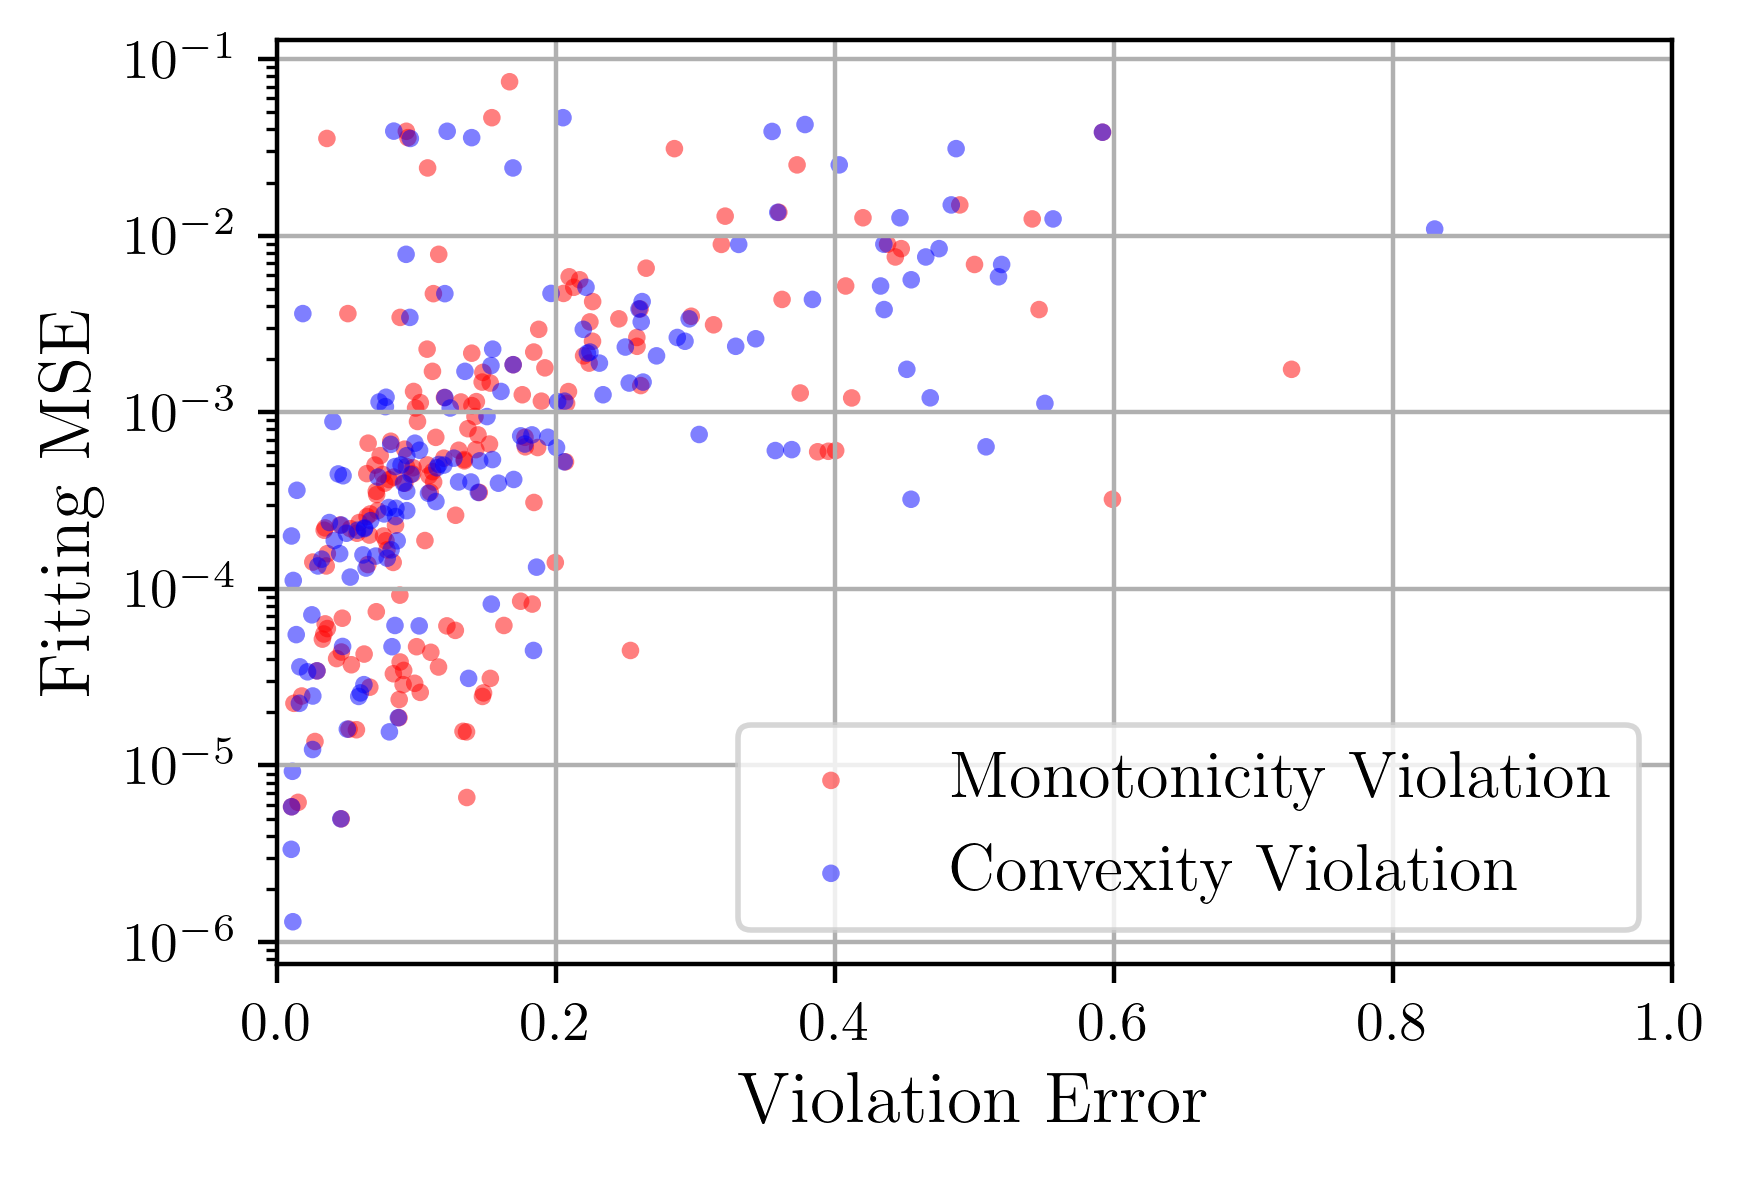

In [13]:
MSE_values = fit_MSE_matrix.flatten()
mono_y_values = mono_matrix_y.flatten()
conv_y_values = conv_matrix.flatten()

# Monotone case (y_values == 0)
valid_mask_mono = ~np.isnan(MSE_values) & ~np.isnan(mono_y_values) & (mono_y_values == 0)
# Monotonicity violated case (y_values > 0)
valid_mask_mono_violated = ~np.isnan(MSE_values) & ~np.isnan(mono_y_values) & (mono_y_values > 0)

# Convexity violated case (y_values > 0)
valid_mask_conv_violated = ~np.isnan(MSE_values) & ~np.isnan(conv_y_values) & (conv_y_values > 0)

# Plotting
plt.figure(figsize=(4.5, 3), dpi=400)
# Scatter points for monotonicity violation
plt.scatter(mono_y_values[valid_mask_mono_violated], MSE_values[valid_mask_mono_violated], alpha=0.5, s=10, c='r', label="Monotonicity Violation", edgecolors='none')
# Scatter points for convexity violation
plt.scatter(conv_y_values[valid_mask_conv_violated], MSE_values[valid_mask_conv_violated], alpha=0.5, s=10, c='b', label="Convexity Violation", edgecolors='none')

plt.xlabel("Violation Error", fontsize=13)
plt.ylabel("Fitting MSE", fontsize=13)
plt.xlim(0,1)
plt.yscale("log")
plt.grid()
plt.legend(loc='lower right', fontsize=12)
plt.show()


In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Data for monotonicity violation
x_mono = mono_y_values[valid_mask_mono_violated]
y_mono = MSE_values[valid_mask_mono_violated]
log_y_mono = np.log(y_mono)

# Data for convexity violation
x_conv = conv_y_values[valid_mask_conv_violated]
y_conv = MSE_values[valid_mask_conv_violated]
log_y_conv = np.log(y_conv)

# Fit linear regression for monotonicity
reg_mono = LinearRegression().fit(x_mono.reshape(-1, 1), log_y_mono)
r2_mono = r2_score(log_y_mono, reg_mono.predict(x_mono.reshape(-1, 1)))

# Fit linear regression for convexity
reg_conv = LinearRegression().fit(x_conv.reshape(-1, 1), log_y_conv)
r2_conv = r2_score(log_y_conv, reg_conv.predict(x_conv.reshape(-1, 1)))

# Print coefficients
print(f"Monotonicity Fit: log(MSE) = {reg_mono.coef_[0]:.4f} * x + {reg_mono.intercept_:.4f}, R² = {r2_mono:.4f}")
print(f"Convexity Fit: log(MSE) = {reg_conv.coef_[0]:.4f} * x + {reg_conv.intercept_:.4f}, R² = {r2_conv:.4f}")


Monotonicity Fit: log(MSE) = 8.7905 * x + -9.0068, R² = 0.2947
Convexity Fit: log(MSE) = 8.7677 * x + -8.9187, R² = 0.4056


In [8]:
from scipy.stats import spearmanr

# Monotonicity violation
rho_mono, pval_mono = spearmanr(x_mono, y_mono)
print(f"Spearman (mono): {rho_mono:.3f}, p = {pval_mono:.3e}")

# Convexity violation
rho_conv, pval_conv = spearmanr(x_conv, y_conv)
print(f"Spearman (conv): {rho_conv:.3f}, p = {pval_conv:.3e}")


Spearman (mono): 0.720, p = 2.623e-29
Spearman (conv): 0.875, p = 3.666e-50


### examples

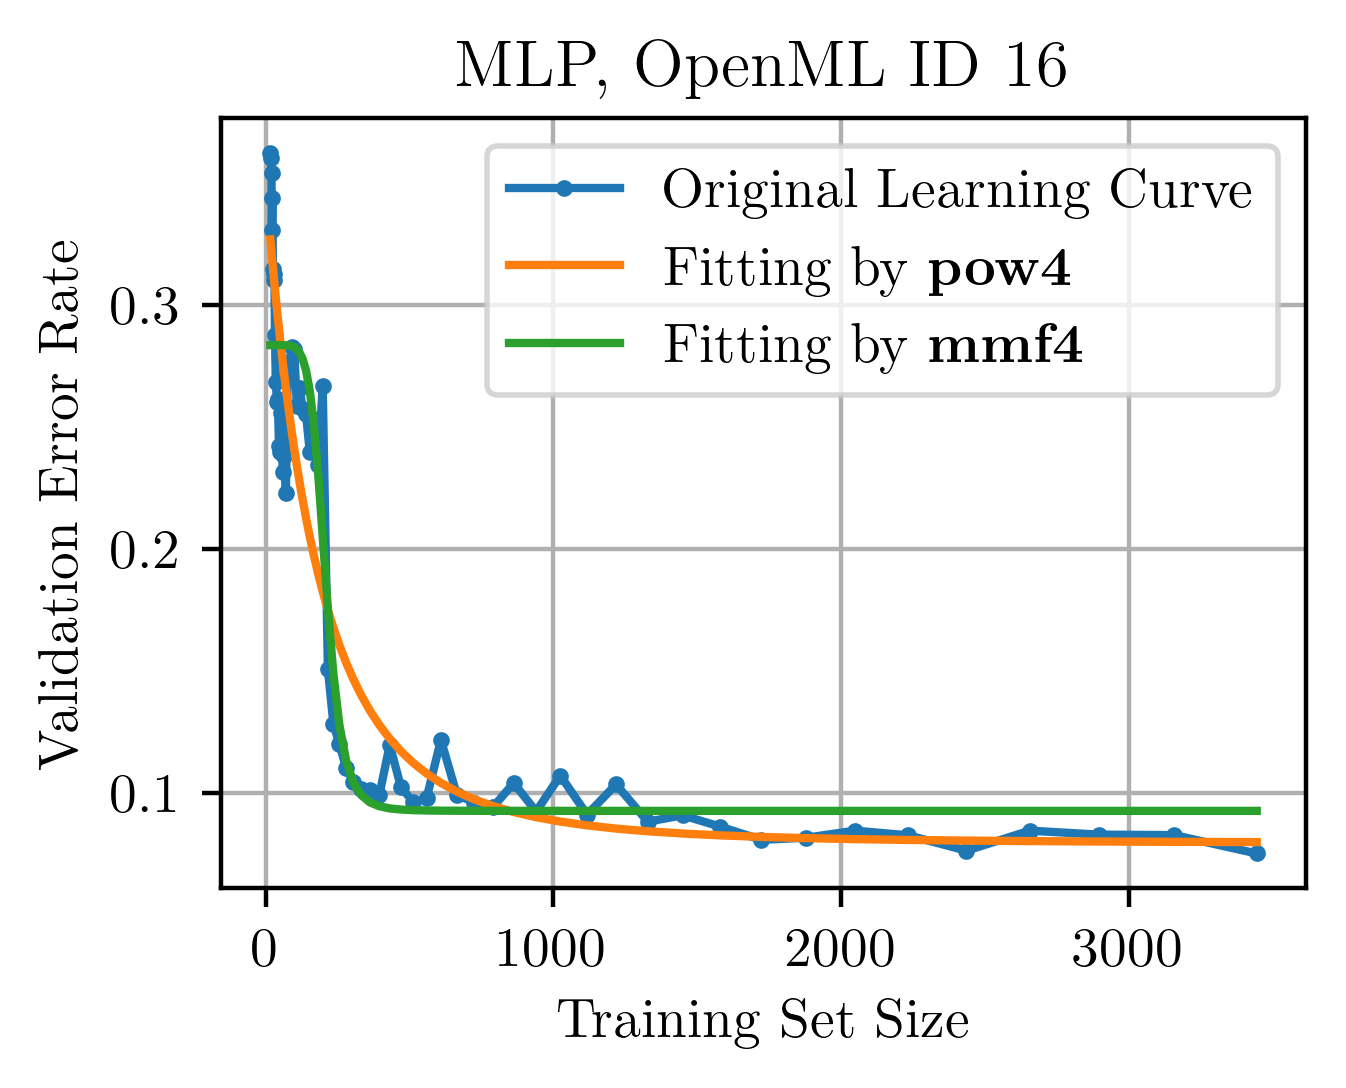

In [5]:
random_learner = random.randint(0, 22) 
random_dataset = random.randint(0, 71)
random_learner, random_dataset = 11, 16
# transition 11, 16 
# peaking 12, 58  # 13, 56 is interesting
# dipping 21, 71

curve_data = mean_valid_lc_nofs[random_dataset, random_learner, :]

fitting_results = curves_models_fitting(
    curve_data, ['pow4'], extrapolate=False, mask_anchor_number=0, eval_anchor_number=0, rep=3
)
result_df = pd.DataFrame(fitting_results)

fitting_results_mmf4 = curves_models_fitting(
    curve_data, ['mmf4'], extrapolate=False, mask_anchor_number=0, eval_anchor_number=0, rep=3
)
result_df_mmf4 = pd.DataFrame(fitting_results_mmf4)

plt.figure(figsize=(3.5, 2.5), dpi=400)
curve_length = result_df['scores'][0].shape[0]
plt.plot(anchor_list_denser[:curve_length], result_df['scores'][0], marker='o', markersize=2, label='Original Learning Curve')
plt.plot(anchor_list_denser[:curve_length], result_df['predictions'][0], label=r'Fitting by $\textbf{pow4}$')
plt.plot(anchor_list_denser[:curve_length], result_df_mmf4['predictions'][0], label=r'Fitting by $\textbf{mmf4}$')

plt.title(f'{learner_zoo[random_learner]}, OpenML ID {random_dataset}')
plt.xlabel('Training Set Size')
plt.ylabel('Validation Error Rate')
plt.legend()
plt.grid(True)
plt.show()
